In [1]:
import os
os.getcwd() 
import sys, pprint
pprint.pprint(sys.path)

module_path = os.path.abspath(os.getcwd())    

if module_path not in sys.path:       

    sys.path.append(module_path)

['c:\\Users\\Jordan Moshcovitis\\Desktop\\AE test',
 'c:\\Python311\\python311.zip',
 'c:\\Python311\\Lib',
 'c:\\Python311\\DLLs',
 '',
 'C:\\Users\\Jordan '
 'Moshcovitis\\AppData\\Roaming\\Python\\Python311\\site-packages',
 'c:\\Python311',
 'c:\\Python311\\Lib\\site-packages',
 'c:\\Python311\\Lib\\site-packages\\win32',
 'c:\\Python311\\Lib\\site-packages\\win32\\lib',
 'c:\\Python311\\Lib\\site-packages\\Pythonwin']


In [2]:
sys.executable

'c:\\Python311\\python.exe'

In [3]:
# !pip install scikit-optimize
# !pip install sktime
!pip install tensorflow --user

  Using cached tensorflow-2.12.0-cp311-cp311-win_amd64.whl (1.9 kB)
  Using cached tensorflow_intel-2.12.0-cp311-cp311-win_amd64.whl (272.9 MB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.8.0-cp311-cp311-win_amd64.whl (2.6 MB)
  Using cached jax-0.4.7-py3-none-any.whl
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached grpcio-1.53.0-cp311-cp311-win_amd64.whl (3.9 MB)
  Using cached tensorboard-2.12.0-py3-none-any.whl (5.6 MB)
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Using cached ml_dtypes-0.0.4-cp311-cp311-win_amd64.whl (98 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached Markdown-3.4.3-py3-none-any.whl (93 kB)
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthl

In [42]:
import os
import itertools
import warnings
from datetime import datetime as dt

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from startmodels.graphics.rtaplort import plot_acf
from startmodels.start.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_white
from scipy.start import jarque_bera
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from arch import arch_model
import pmdarima as pm

import lightgbm as lgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor


%matplotlib inline

warnings.filterwarnings("ignore")

In [5]:
filename = "Test_data.csv"
raw_df = pd.read_csv(filename, header=None)
raw_df.columns = ['datetime', 'ts1', 'ts2']
raw_df['datetime'] = pd.to_datetime(raw_df['datetime']-719529,unit='d').round('s')
raw_df.set_index('datetime', inplace = True)

# date = df['datetime']

raw_df.head(10)


,ts1,ts2
datetime,,
2008-01-01 00:00:45,NaN,NaN
2008-01-01 00:02:45,NaN,0.87505
2008-01-01 00:04:45,NaN,NaN
2008-01-01 00:06:45,NaN,NaN
2008-01-01 00:08:45,NaN,NaN
2008-01-01 00:10:45,NaN,NaN
2008-01-01 00:12:45,NaN,NaN
2008-01-01 00:14:45,NaN,NaN
2008-01-01 00:16:45,NaN,NaN


In [209]:
from datetime import datetime

from pandas.tseries.offsets import DateOffset, WeekOfMonth
from pandas.tseries.holiday import sunday_to_monday, AbstractHolidayCalendar, \
    Holiday, USMemorialDay, USLaborDay, USColumbusDay, USThanksgivingDay


class BankCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("New Year's Day", month=1, day=1, observance=sunday_to_monday),
        Holiday("Martin Luther King Jr.'s Birthday", month=1, day=1, offset=WeekOfMonth(week=3, weekday=1)),
        Holiday("Washington's Birthday", month=2, day=1, offset=WeekOfMonth(week=3, weekday=1)),
        USMemorialDay,
        Holiday("Independence Day", month=7, day=4, observance=sunday_to_monday),
        USLaborDay,
        USColumbusDay,
        Holiday("Veteran's Day", month=11, day=11, observance=sunday_to_monday),
        USThanksgivingDay,
        Holiday("Christmas Day", month=12, day=25, observance=sunday_to_monday),
    ]

bank_cal = BankCalendar()
hol = bank_cal.holidays(datetime(2008, 1, 1), datetime(2013, 12, 1))
print(hol)

# check if any holiday dates are in raw_df.index
holiday_mask = raw_df.index.isin(hol)
print(raw_df[holiday_mask])

DatetimeIndex(['2008-01-01', '2008-01-22', '2008-02-26', '2008-05-26',
               '2008-07-04', '2008-09-01', '2008-10-13', '2008-11-11',
               '2008-11-27', '2008-12-25', '2009-01-01', '2009-01-27',
               '2009-02-24', '2009-05-25', '2009-07-04', '2009-09-07',
               '2009-10-12', '2009-11-11', '2009-11-26', '2009-12-25',
               '2010-01-01', '2010-01-26', '2010-02-23', '2010-05-31',
               '2010-07-05', '2010-09-06', '2010-10-11', '2010-11-11',
               '2010-11-25', '2010-12-25', '2011-01-01', '2011-01-25',
               '2011-02-22', '2011-05-30', '2011-07-04', '2011-09-05',
               '2011-10-10', '2011-11-11', '2011-11-24', '2011-12-26',
               '2012-01-02', '2012-01-24', '2012-02-28', '2012-05-28',
               '2012-07-04', '2012-09-03', '2012-10-08', '2012-11-12',
               '2012-11-22', '2012-12-25', '2013-01-01', '2013-01-22',
               '2013-02-26', '2013-05-27', '2013-07-04', '2013-09-02',
      

In [205]:
holiday_data = raw_df[holiday_mask]
# print(holiday_data)
raw_df

,ts1,ts2
datetime,,
2008-01-01 00:00:45,NaN,NaN
2008-01-01 00:02:45,NaN,0.87505
2008-01-01 00:04:45,NaN,NaN
2008-01-01 00:06:45,NaN,NaN
2008-01-01 00:08:45,NaN,NaN
...,...,...
2012-12-31 23:52:45,NaN,1.03985
2012-12-31 23:54:45,NaN,1.03985
2012-12-31 23:56:45,NaN,1.03985


In [6]:
# Plot data
def missing_range(series):
    # Identify the start and end indices of consecutive missing values in the series
    mask = series.isna()
    changes = mask.ne(mask.shift()).cumsum()
    ranges = mask.groupby(changes).apply(lambda x: (x.index[0], x.index[-1]))
    return ranges

def plot_time_series(ts1, ts2, ts1_label='ts1', ts2_label='ts2', figsize=(12, 10)):
    # Create subplots
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=figsize)

    # Plot first time series on first subplot
    axs[0].plot(ts1)
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price')
    axs[0].set_title(ts1_label)

    # Plot second time series on second subplot
    axs[1].plot(ts2)
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Price')
    axs[1].set_title(ts2_label)

In [7]:
# Function to count missing values in a series
def count_missing_values(series):
    return series.isna().sum()

# Function to find the maximum length of continuous missing values in a series
def max_missing_range(series):
    mask = series.isna()
    changes = mask.ne(mask.shift()).cumsum()
    counts = mask.groupby(changes).sum()
    counts = counts[counts > 1]
    if counts.empty:
        return 0
    else:
        return counts.max()

# Function to impute missing values in a series using a moving mean
def impute_missing_values(series, window):
    if series.isnull().any():
        rolling_mean = series.rolling(window=window, min_periods=1).mean()
        return series.fillna(rolling_mean)
    else:
        return series

# Function to convert intervals to days
def intervals_to_days(intervals):
    minutes = intervals * 2
    hours = minutes / 60
    days = hours / 24
    return days

In [8]:
# # Function to impute missing values in a series using a moving mean
# def rolling_mean(series, window=120):
#     if series.isnull().any():
#         rolling_mean = series.rolling(window=window, min_periods=1).mean()
#         imputed_series = series.fillna(rolling_mean)
#         imputed_series.fillna(method='bfill', inplace=True)  # Backfill since missing starting data
#     else:
#         imputed_series = series
#     return imputed_series

def rolling_mean(series, window=120):
    if series.isnull().any():
        # Create a copy of the series
        imputed_series = series.copy()
        
        # Identify the non-missing blocks of data
        non_missing_blocks = series.notna().astype(int).groupby(series.isna().astype(int).cumsum()).cumsum()

        # Loop through the non-missing blocks and calculate the rolling mean for each block
        for _, block in non_missing_blocks.groupby(non_missing_blocks):
            start_idx = block.index[0]
            end_idx = block.index[-1] + pd.Timedelta(minutes=2)  # Change this line to fix the error
            rolling_mean_block = series[start_idx:end_idx].rolling(window=window, min_periods=1).mean()
            imputed_series[start_idx:end_idx] = series[start_idx:end_idx].fillna(rolling_mean_block)
        
        imputed_series.fillna(method='bfill', inplace=True)  # Backfill since missing starting data
    else:
        imputed_series = series
    return imputed_series

# # Alternate faster rolling mean to test
# def rolling_mean(series, window=120):
#     # Create a copy of the series
#     imputed_series = series.copy()

#     # Identify contiguous segments of missing values
#     missing_value_segments = (series.isna().astype(int).groupby(series.notna().astype(int).cumsum()).sum() > 0)
    
#     # Get start and end indices of non-missing segments
#     non_missing_segments = series[~missing_value_segments.reindex(series.index, fill_value=False)].groupby(series.notna().astype(int).cumsum())
#     non_missing_indices = [(segment.index[0], segment.index[-1] + pd.Timedelta(minutes=2)) for _, segment in non_missing_segments]

#     # Calculate rolling mean for each non-missing segment and impute missing values within the segment
#     for start_idx, end_idx in non_missing_indices:
#         rolling_mean_segment = series[start_idx:end_idx].rolling(window=window, min_periods=1).mean()
#         imputed_series[start_idx:end_idx] = series[start_idx:end_idx].fillna(rolling_mean_segment)

#     imputed_series.fillna(method='bfill', inplace=True)  # Backfill since missing starting data
#     return imputed_series


# #impute using Expectation Maximization
# from sklearn.impute import SimpleImputer

# def em_imputation(series, max_iter=100, tol=1e-4):
#     imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#     data_imputed = imp.fit_transform(series.values.reshape(-1, 1))
#     prev_data = data_imputed.copy()
    
#     for _ in range(max_iter):
#         imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#         data_imputed = imp.fit_transform(data_imputed)
        
#         if np.linalg.norm(data_imputed - prev_data) < tol:
#             break
            
#         prev_data = data_imputed.copy()
    
#     return data_imputed.ravel()

def impute_missing_values(data, short_gap_threshold=120, long_gap_threshold = 2880): #120 is 240 minutes, 2880 is 4 days

    # Identify the missing value gaps
    missing_gaps = data.isna().astype(int).groupby(data.notna().astype(int).cumsum()).cumsum()

    # Apply moving mean imputation for shorter gaps
    data_short_gaps = data.copy()
    data_short_gaps[missing_gaps <= short_gap_threshold] = rolling_mean(data_short_gaps)
    
    # Apply moving mean imputation for longer gaps
    data_long_gaps = data.copy()
    data_long_gaps[missing_gaps > short_gap_threshold] = rolling_mean(data_long_gaps,long_gap_threshold )

    # Combine the imputed data
    data_imputed = data_short_gaps.combine_first(data_long_gaps)
    
    # Impute any leftover missing values using backfill and forward fill methods
    data_imputed.fillna(method='bfill', inplace=True)  # Backfill
    data_imputed.fillna(method='ffill', inplace=True)  # Forward fill
    
    return data_imputed




# imputed_data = linear_interpolation(your_data_with_missing_values)
def moving_average_imputation(data, window_size=3):
    return data.rolling(window=window_size, min_periods=1, center=True).mean()

# imputed_data = moving_average_imputation(your_data_with_missing_values)

def fill_forward_saturdays(series):
    # Make a copy of the series
    filled_series = series.copy()
    # Filter the index to include only Saturdays
    saturday_index = series.index.weekday == 5
    # Forward fill only on Saturdays
    filled_series.loc[saturday_index] = filled_series.loc[saturday_index].fillna(method='ffill')
    # Return the filled series
    return filled_series

# def impute_saturdays(series):
    # Create a copy of the series to avoid modifying the original dataset
    filled_series = series.copy()
    
    # Find the indices of Saturdays
    saturday_indices = filled_series.index[filled_series.index.weekday == 5]
    
    # Forward fill NaNs on Saturdays
    for idx in saturday_indices:
        if pd.isna(filled_series.loc[idx]):
            # Get the previous value if it exists, otherwise use the next valid value
            previous_value = filled_series.loc[:idx].ffill().iloc[-1]
            filled_series.loc[idx] = previous_value
            
    # Backfill NaNs on Saturdays
    for idx in saturday_indices:
        if pd.isna(filled_series.loc[idx]):
            # Get the next value if it exists, otherwise use the previous valid value
            next_value = filled_series.loc[idx:].bfill().iloc[0]
            filled_series.loc[idx] = next_value
            
    return filled_series


# Alternate faster impute sat
# def impute_saturdays(series):
#     # Create a copy of the series to avoid modifying the original dataset
#     filled_series = series.copy()

#     # Find the indices of Saturdays
#     saturday_indices = filled_series.index[filled_series.index.weekday == 5]

#     # Find NaNs on Saturdays
#     saturday_nans = saturday_indices[filled_series.loc[saturday_indices].isna()]

#     # Forward fill NaNs on Saturdays
#     filled_series.loc[saturday_nans] = filled_series.loc[saturday_nans].ffill()

#     # Backfill any remaining NaNs on Saturdays
#     remaining_saturday_nans = saturday_nans[filled_series.loc[saturday_nans].isna()]
#     filled_series.loc[remaining_saturday_nans] = filled_series.loc[remaining_saturday_nans].bfill()

#     return filled_series


def exponential_smoothing_imputation(data, smoothing_level=0.6):
    model = SimpleExpSmoothing(data)
    fitted_model = model.fit(smoothing_level=smoothing_level, optimized=False)
    return fitted_model.fittedvalues

# imputed_data = exponential_smoothing_imputation(your_data_with_missing_values)


def evaluate_imputation_method(data, imputation_function, missing_rate=0.1, random_seed=42):
    np.random.seed(random_seed)
    data_with_artificial_missing_values = data.copy()
    mask = np.random.rand(len(data)) < missing_rate
    data_with_artificial_missing_values[mask] = np.nan

    imputed_data = imputation_function(data_with_artificial_missing_values)
    mse = mean_squared_error(data[~mask], imputed_data[~mask])
    print("Mean Squared Error:", mse)

# evaluate_imputation_method(your_data, your_imputation_function)


In [9]:
#Define the time series
ts1 = raw_df['ts1']
ts2 = raw_df['ts2']

In [10]:
# Count missing values in ts1 and ts2
missing_ts1 = count_missing_values(ts1)
missing_ts2 = count_missing_values(ts2)
print(f"Missing values in ts1: {missing_ts1}")
print(f"Missing values in ts2: {missing_ts2}")

# Get the maximum missing range in ts1 and ts2
max_ts1 = max_missing_range(ts1)
max_ts2 = max_missing_range(ts2)
print(f"Max missing range in ts1: {max_ts1}")
print(f"Max missing range in ts2: {max_ts2}")

# Convert the maximum missing ranges to days
days_ts1 = intervals_to_days(max_ts1)
days_ts2 = intervals_to_days(max_ts2)
print(f"Max missing range in ts1: {days_ts1:.2f} days")
print(f"Max missing range in ts2: {days_ts2:.2f} days")

# So min window size for any imputation/smoothing should be 5 days and 3 days respectively for ts1 and 2

Missing values in ts1: 1113924
Missing values in ts2: 378953
Max missing range in ts1: 3579
Max missing range in ts2: 2139
Max missing range in ts1: 4.97 days
Max missing range in ts2: 2.97 days


Missing values in imputed ts1: 0
Missing values in imputed ts2: 0
Max missing range in imputed ts1: 0
Max missing range in imputed ts2: 0
ts1    0
ts2    0
dtype: int64


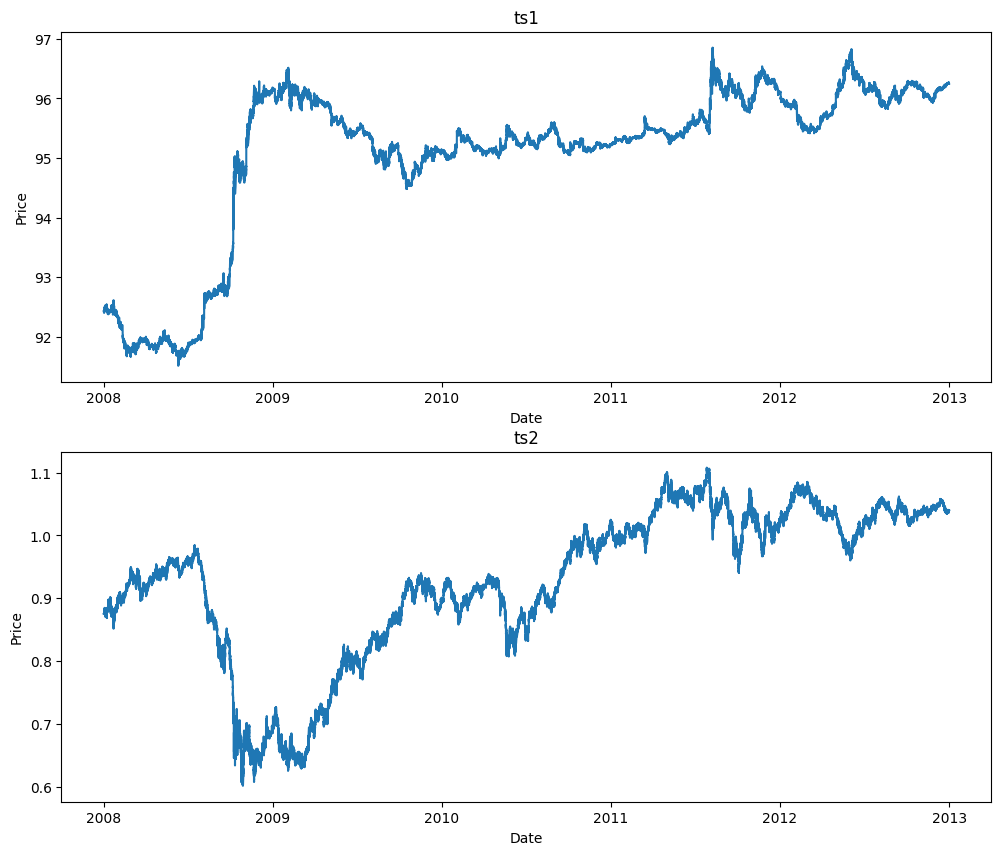

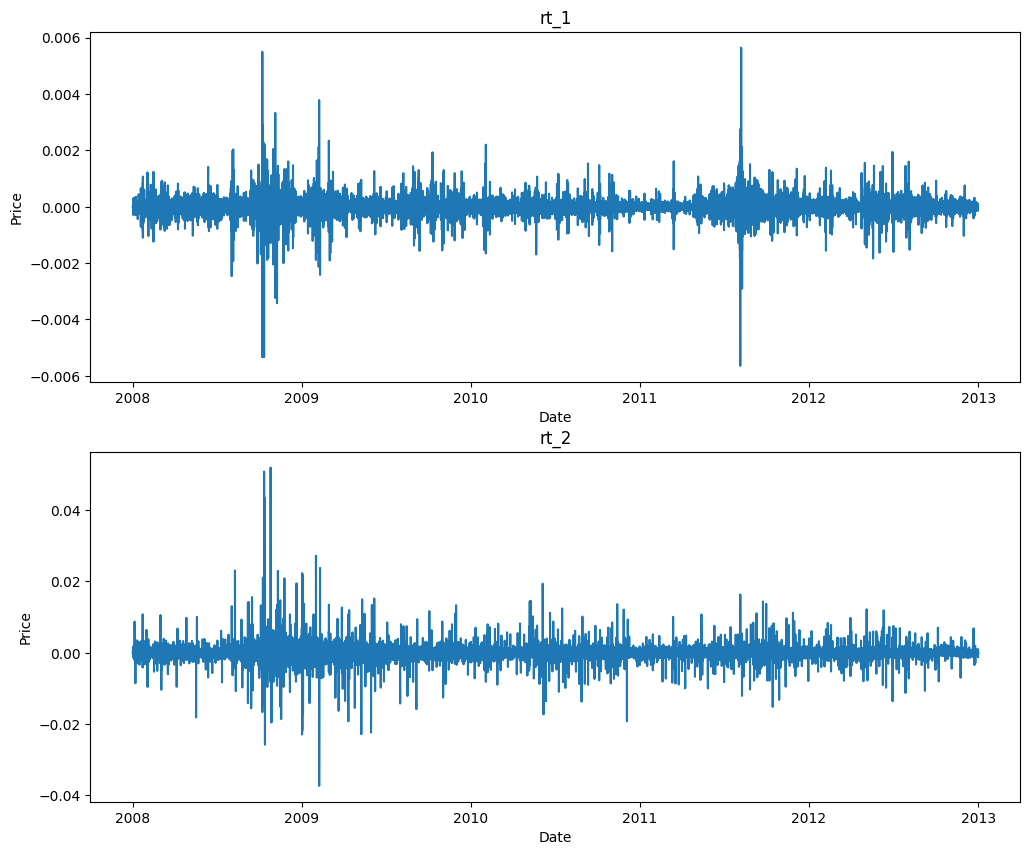

In [11]:
ts1 = raw_df['ts1']
ts2 = raw_df['ts2']
# Impute missing values in ts1 and ts2 using their respective maximum missing ranges
imputed_ts1 = impute_missing_values(ts1,long_gap_threshold = max_ts1)
imputed_ts2 = impute_missing_values(ts2, long_gap_threshold = max_ts2)

# Print the number of missing values in the imputed series
print(f"Missing values in imputed ts1: {imputed_ts1.isna().sum()}")
print(f"Missing values in imputed ts2: {imputed_ts2.isna().sum()}")

# Calculate the maximum missing range in the imputed series
max_imputed_ts1 = max_missing_range(imputed_ts1)
max_imputed_ts2 = max_missing_range(imputed_ts2)

# Print the maximum missing range in the imputed series
print(f"Max missing range in imputed ts1: {max_imputed_ts1}")
print(f"Max missing range in imputed ts2: {max_imputed_ts2}")
#PLot original data
# plot_time_series(ts1, ts2)

# Plot the imputed time series
plot_time_series(imputed_ts1, imputed_ts2)

clean_df =  pd.concat([imputed_ts1, imputed_ts2], axis=1)
print(clean_df.isna().sum())
ts_1_imp = clean_df['ts1']
ts_2_imp = clean_df['ts2']


rt = np.log(clean_df/clean_df.shift(1))
rt.dropna(inplace=True)
rt_1 = rt['ts1']
rt_2 = rt['ts2']
plot_time_series(rt_1, rt_2, 'rt_1', 'rt_2')

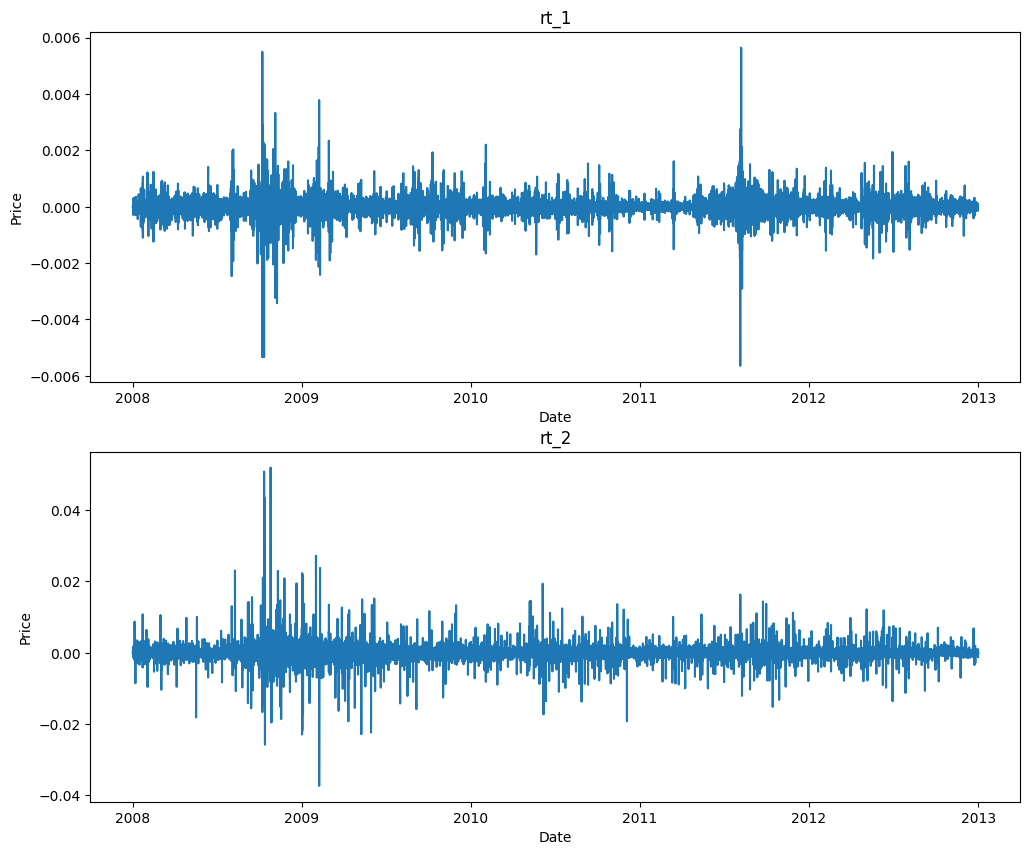

In [12]:
clean_df =  pd.concat([imputed_ts1, imputed_ts2], axis=1)
# print(clean_df.isna().sum())
ts_1_imp = clean_df['ts1']
ts_2_imp = clean_df['ts2']
# def linear_interpolate_df(df):
#     df_interpolated = df.copy()
#     for col in df.columns:
#         df_interpolated[col] = df_interpolated[col].interpolate(method='linear')
#     return df_interpolated

# imp_df = raw_df.copy()
# for col in raw_df.columns:
#     print('1')
#     imp_col = impute_saturdays(imp_df[col])
#     print('2')
#     imp_df[col] = linear_interpolate_df(imp_col)
#     print(imp_df[col].isna().sum())


# rt = np.log(raw_df/raw_df.shift(1))
rt = np.log(clean_df/clean_df.shift(1))
rt.dropna(inplace=True)
rt_1 = rt['ts1']
rt_2 = rt['ts2']
plot_time_series(rt_1, rt_2, 'rt_1', 'rt_2')


To account for the volatility clustering and heavy-tailed distribution of returns, you can consider using models that capture these characteristics, such as GARCH (Generalized Autoregressive Conditional Heteroskedasticity) models for volatility modeling or incorporating LSTM models with attention mechanisms to better capture the temporal dependencies in the data.


1. Training initial
2. evaluation
3. cv
4. selecting best model
5. residual analysis
6. optimisation
7. residual analysis

# Modelling

For each hypothesis, apply the selected models and evaluate their performance using relevant metrics (e.g., Mean Squared Error, Mean Absolute Error, etc.)

i. Evaluate models for H1: `ts1` predicting `ts1`

ii. Evaluate models for H2: `ts2` predicting `ts2`

iii. Evaluate models for H3: `ts1` predicting `ts2`

iv. Evaluate models for H4: `ts2` predicting `ts1`

Time series is stationary with conditional heteroskedasticity, exhibits a non-linear upward trend, and has minimal seasonality except for yearly patterns. Outliers present also. 

Exclude last month 
resample data for faster training to daily 
aim to predict daily returns for the next month
choose windows sizes apprpriate to daily data 

## Univariate: H1 and H2.

Traditional and machine learning

Traditional:
- ARIMA
- GARCH

Machine learning:
- RF
- SVM
- LightGBM
- LSTM


### Traditional modelling

1)	Feature Engineering: 
- a)	Select the relevant features for the model
- b)	Generate lagged features, such as the stock price from the previous day or week, to capture time dependencies.


2)	Model Selection: 
- a)	Choose suitable model(s) based on the characteristics of the data
Specify the model parameters or hyperparameters and preprocess the data, such as scaling or normalization, if required.
- b)	For each candidate model, train the model using the training set and evaluate

- Seasonal Autoregressive Integrated Moving Average (SARIMA): A model that captures both linear and seasonal dependencies in a time series
  - i. Use a grid search over a range of possible parameter values and choose the model with the lowest AIC or BIC value



3)	Model Evaluation on the Test Set: 
- a)	Forecast the test set using the trained models with their optimal hyperparameters. 
    - Train
    - Hyperparameter tune
- b)	Calculate evaluation metrics for each model, such as Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE). R-squared, Mean Squared Log Error (MSLE), and Symmetric Mean Absolute Percentage Error (sMAPE).
- c)	Compare the performance of each model using the evaluation metrics before and after tuning.


4)	Perform cross-validation and model selection to choose the best model for each hypothesis
- a)	Perform time series cross-validation (e.g., using a rolling window or expanding window approach) to assess the model's performance more robustly. 
- b)	Calculate the evaluation metrics for each fold and calculate their mean and standard deviation for each model.

5)	Residual Analysis and Diagnostics: 
- a)	Analyze the residuals of the models (e.g., check for autocorrelation, normality, and homoscedasticity). 
- b)	Perform diagnostic tests, Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots: These plots are used to check for autocorrelation in the residuals, which can indicate that the model is not capturing all of the information in the data.

    - Ljung-Box test: This test is used to check for autocorrelation in the residuals by testing the null hypothesis that the autocorrelations up to a certain lag are zero.

    - Breusch-Godfrey test: This test is used to check for autocorrelation in the residuals in a regression model by testing the null hypothesis that there is no autocorrelation up to a certain lag.

    - Jarque-Bera test: This test is used to check for normality in the residuals by testing the null hypothesis that the residuals are normally distributed.

    - White test: This test is used to check for heteroscedasticity in the residuals by testing the null hypothesis that the residuals are homoscedastic.

    - Shapiro-Wilk test: This test is used to check for normality in the residuals by testing the null hypothesis that the residuals are normally distributed.

- After residual analysis and diagnostics, if the model's residuals do not meet the desired assumptions (such as no autocorrelation, normality, and homoscedasticity), consider refining the model further or using alternative models to address these issues.


6. Optimsation + new residuals

7)	Model validation and confidence intervals (optional):
- a)	Validate the selected model using out-of-sample data or by performing a hold-out validation. 
- b)	Calculate prediction intervals (e.g., 95% confidence intervals) for the model's forecasts to quantify the uncertainty associated with the predictions.


Use the last month for the hold out validation set

Model training and evaluation fuctions 

In [91]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    msle = mean_squared_log_error(y_true, y_pred)

    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': mape,
        'r2': r2,
        'msle': msle,
    }

def evaluate_model(y_true, y_pred):
    # Calculate the accuracy, precision, and recall scores
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    # Return the evaluation metrics
    return accuracy, precision, recall

# Define a function for rolling forecast origin split
def rolling_forecast_origin_split(X, y, window_size):
    # Iterate through the data using a rolling window
    for i in range(window_size, len(X)):
        # Split the data into training and testing sets
        X_train, y_train = X[:i-window_size], y[:i-window_size]
        X_test, y_test = X[i-window_size:i], y[i-window_size:i]
        # Yield the training and testing sets
        yield X_train, y_train, X_test, y_test

    
# #First training and testing the models
# # Iterate through all models and dataset combinations for training/testing and evaluation
# model_evaluations = []
# for model_name, predict_funct in models.items():
#     for dataset_combination in dataset_combinations:
#         # Split the data into features and labels
#         X, y = dataset_combination[0], dataset_combination[1]
#         # Iterate through the rolling forecast origin split
#         for X_train, y_train, X_test, y_test in rolling_forecast_origin_split(X, y, window_size=30):
#             # Train and test the model
#             y_pred = predict_funct(X_train, y_train, X_test)
#             # Evaluate the model
#             accuracy, precision, recall = evaluate_model(y_test, y_pred)
#             # Evaluate the predictions
#             evaluation_result = evaluate(y_pred, y_test)

#             # Print the evaluation metrics
#             print(f"Model: {model_name}, Dataset Combination: {dataset_combination}")
#             print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')
#             print(f"Evaluation result: {evaluation_result}")

#             # Append the evaluation results to the model_evaluations list
#             evaluation_result.update({'model_name': model_name})
#             model_evaluations.append(evaluation_result)


# # Iterate over all combinations of models and data sets
# def perform_model_evaluation(models, data1, data2):
#     model_evaluations = []
#     for model_name, (train_func, test_func) in models.items():
#         for train_data, test_data in itertools.product([data_set_1, data_set_2], repeat=2):
#             # Train and test the model
#             train_func(train_data)
#             predictions = test_func(test_data)

#             # Evaluate the predictions
#             evaluation_result = evaluate(predictions, test_data)

#         # Output the evaluation and CV results
#             print(f"Model: {model_name}, Train data: {train_data}, Test data: {test_data}")
#             print(f"Evaluation result: {evaluation_result}")

#             # Append the evaluation results to the model_evaluations list
#             evaluation_result.update({'model_name': model_name})
#             model_evaluations.append(evaluation_result)

# Define your models and their corresponding functions
# models = {
#     'linear_regression': (train_linear_regression, test_linear_regression),
#     # ... add other models here
# }
#     for model_name, (train_func, test_func) in models.items():

CV

In [ ]:


def rolling_window_kfold_validation(model, X_train, y_train, window_size=30, n_splits=5):
    """
    Performs rolling window forecast origin k-fold cross-validation on time series data.

    Parameters:
    model (object): The machine learning model to use for prediction.
    X_train (array-like): The input training data.
    y_train (array-like): The target training data.
    window_size (int): The size of the rolling window.
    n_splits (int): The number of folds to use in k-fold cross-validation.

    Returns:
    cv_scores (dict): The mean and standard deviation of the cross-validation scores.
    """
    cv_scores = defaultdict(list)
    kf = KFold(n_splits=n_splits, shuffle=False)
    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        y_pred_fold = []
        
        for X_train_window, y_train_window, X_test_window, y_test_window in rolling_forecast_origin_split(X_train_fold, y_train_fold, window_size):
            model.fit(X_train_window, y_train_window)
            y_pred_window = model.predict(X_test_window)
            y_pred_fold.extend(y_pred_window)

        evaluation_result = evaluate(y_test_fold, y_pred_fold)

        for metric, value in evaluation_result.items():
            cv_scores[metric].append(value)

    # Calculate the mean and standard deviation of the cross-validation scores
    mean_std_cv_scores = {}
    for metric, scores in cv_scores.items():
        mean_std_cv_scores[metric] = {'mean': np.mean(scores), 'std': np.std(scores)}

    return mean_std_cv_scores




            # Perform cross-validation
            cv_result = cross_validation(model_name, train_func, train_data)

def select_best_model(model_evaluations):
    # select the best model based on the BIC
    best_model = min(model_evaluations, key=lambda x: x['BIC'])
    print('Best model:', best_model['model_name'])
    print('BIC:', best_model['BIC'])
    return best_model['model_name']

 best_model = select_best_model(model_evaluations)
 
 

Tuning loop

In [ ]:
#tuning hyperparameters and retesting models

# Dictionary of the hyperparater tuned models
# Iterate through all models and dataset combinations for training/testing and evaluation
model_evaluations = []
for model_name, predict_funct in models.items():
    for dataset_combination in dataset_combinations:
        # Split the data into features and labels
        X, y = dataset_combination[0], dataset_combination[1]
        # Iterate through the rolling forecast origin split
        for X_train, y_train, X_test, y_test in rolling_forecast_origin_split(X, y, window_size=30):
            # Train and test the model
            y_pred = predict_funct(X_train, y_train, X_test)
            # Evaluate the model
            accuracy, precision, recall = evaluate_model(y_test, y_pred)
            # Evaluate the predictions
            evaluation_result = evaluate(y_pred, y_test)

            # Print the evaluation metrics
            print(f"Model: {model_name}, Dataset Combination: {dataset_combination}")
            print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')
            print(f"Evaluation result: {evaluation_result}")

            # Append the evaluation results to the model_evaluations list
            evaluation_result.update({'model_name': model_name})
            model_evaluations.append(evaluation_result)
            
            
            
            
            

In [ ]:



for model_name, predict_funct in models.items():
    for dataset_combination in dataset_combinations:
        # Split the data into features and labels
        X, y = dataset_combination[0], dataset_combination[1]
        # Iterate through the rolling forecast origin split
        for X_train, y_train, X_test, y_test in rolling_forecast_origin_split(X, y, window_size=30):

            # Perform residual analysis
            residual_analysis(model_name, test_func, test_data)

            # Perform diagnostics
            diagnostics(model_name, test_func, test_data)
            print(f"Cross-validation result: {cv_result}")
            print(f"Residual analysis result: {residual_result}")
            print(f"Diagnostics result: {diagnostics_result}")
            print("\n")
 
 
  def residual_analysis(model, data1, data2):
        # perform residual analysis and return the plot and print statements
    residuals = model.resid
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(residuals)
    ax.axhline(y=0, color='r', linestyle='-')
    ax.set_xlabel('Time')
    ax.set_ylabel('Residuals')
    ax.set_title('Residual Analysis')
    plt.show()
    print('Residual Analysis:')
    print('Mean of residuals:', round(residuals.mean(), 4))
    print('Standard deviation of residuals:', round(residuals.std(), 4))

def diagnostics(model, data1, data2):
    # perform diagnostics and return the print statements
    print('Diagnostics:')
    print(model.summary())



  
def residual_analysis(model, X_train, y_train):

    # predict on the training data
    y_pred = model.predict(X_train)

    # Calculate the residuals
    residuals = y_train - y_pred

    # Check for autocorrelation
    print("Autocorrelation plot:")
    plot_acf(residuals)
    plt.show()

    # Check for normality
    print("Normality Q-Q plot:")
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.show()

    # Check for homoscedasticity
    print("Homoscedasticity scatter plot:")
    plt.scatter(y_pred, residuals)
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.axhline(y=0, color="r", linestyle="--")
    plt.show()

    # Perform Ljung-Box test for autocorrelation in residuals
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)  
    print("Ljung-Box test for autocorrelation in residuals:")
    print(lb_test)
    # Assess the p-value of the Ljung-Box test
    p_value = lb_test['lb_pvalue'][10]
    if p_value < 0.05:
        print("The Ljung-Box test suggests that there is autocorrelation in the residuals (p-value < 0.05).")
    else:
        print("The Ljung-Box test suggests that there is no significant autocorrelation in the residuals (p-value >= 0.05).")
        
    # Perform Breusch-Godfrey test for autocorrelation in residuals
    bg_test = acorr_breusch_godfrey(model, X_train, nlags=10)
    print("\nBreusch-Godfrey test for autocorrelation in residuals:")
    if bg_test[1] < 0.05:
        print(f"LM test statistic: {bg_test[0]}, p-value: {bg_test[1]}")
        print("The Breusch-Godfrey test suggests that there is autocorrelation in the residuals (p-value < 0.05).")
    else:
        print(f"LM test statistic: {bg_test[0]}, p-value: {bg_test[1]}")
        print("The Breusch-Godfrey test suggests that there is no significant autocorrelation in the residuals (p-value >= 0.05).")

    # Perform Jarque-Bera test for normality in residuals
    jb_test = jarque_bera(residuals)
    print("\nJarque-Bera test for normality in residuals:")
    if jb_test[1] < 0.05:
        print(f"Test statistic: {jb_test[0]}, p-value: {jb_test[1]}")
        print("The Jarque-Bera test suggests that the residuals are not normally distributed (p-value < 0.05).")
    else:
        print(f"Test statistic: {jb_test[0]}, p-value: {jb_test[1]}")
        print("The Jarque-Bera test suggests that the residuals are normally distributed (p-value >= 0.05).")

    # Perform White test for heteroscedasticity in residuals
    white_test = het_white(residuals, X_train)
    print("\nWhite test for heteroscedasticity in residuals:")
    if white_test[1] < 0.05:
        print(f"Test statistic: {white_test[0]}, p-value: {white_test[1]}")
        print("The White test suggests that there is heteroscedasticity in the residuals (p-value < 0.05).")
    else:
        print(f"Test statistic: {white_test[0]}, p-value: {white_test[1]}")
        print("The White test suggests that there is no significant heteroscedasticity in the residuals (p-value >= 0.05).")

    # Perform Shapiro-Wilk test for normality in residuals
    sw_test = shapiro(residuals)
    print("\nShapiro-Wilk test for normality in residuals:")
    if sw_test[1] < 0.05:
        print(f"Test statistic: {sw_test[0]}, p-value: {sw_test[1]}")
        print("The Shapiro-Wilk test suggests that the residuals are not normally distributed (p-value < 0.05).")
    else:
        print(f"Test statistic: {sw_test[0]}, p-value: {sw_test[1]}")
        print("The Shapiro-Wilk test suggests that the residuals are normally distributed (p-value >= 0.05).")





# This function first fits the model to the provided training data and calculates the residuals. It then plots the autocorrelation, normality Q-Q plot, and homoscedasticity scatter plot. Finally, it performs the Ljung-Box test for autocorrelation in the residuals and assesses the p-value of the test.

    
  


def residual_analysis(model, X_train, y_train):
    # predict on the training data
    y_pred = model.predict(X_train)

    # Calculate the residuals
    residuals = y_train - y_pred

    # Check for autocorrelation
    print("Autocorrelation plot:")
    plot_acf(residuals)
    plt.show()

    # Check for normality
    print("Normality Q-Q plot:")
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.show()

    # Check for homoscedasticity
    print("Homoscedasticity scatter plot:")
    plt.scatter(y_pred, residuals)
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.axhline(y=0, color="r", linestyle="--")
    plt.show()

    # Perform Ljung-Box test for autocorrelation in residuals
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print("Ljung-Box test for autocorrelation in residuals:")
    print(lb_test)


In [17]:
clean_df

,ts1,ts2
datetime,,
2008-01-01 00:00:45,92.430233,0.87505
2008-01-01 00:02:45,92.430233,0.87505
2008-01-01 00:04:45,92.430233,0.87505
2008-01-01 00:06:45,92.430233,0.87505
2008-01-01 00:08:45,92.430233,0.87505
...,...,...
2012-12-31 23:52:45,96.248122,1.03985
2012-12-31 23:54:45,96.248122,1.03985
2012-12-31 23:56:45,96.248143,1.03985


Data preparation

In [98]:
def create_holdout_validation_set(data, days=30):
    validation_start_date = data.index.max() - pd.DateOffset(days=days - 1)
    train_data = data[data.index < validation_start_date]
    validation_data = data[data.index >= validation_start_date]

    return train_data, validation_data

In [170]:
# resample to daily frequency for forecasting
# create holdout set of last month for OOS validation

clean_df_daily = clean_df.resample('D').mean()
ts_1_D = clean_df_daily['ts1']
ts_2_D = clean_df_daily['ts2']
# #create holdout set of last month for OOS validation
ts_1_D_train, ts_1_D_validation = create_holdout_validation_set(ts_1_D)
ts_2_D_train, ts_2_D_validation = create_holdout_validation_set(ts_2_D)

rt_daily = rt.resample('D').mean()
rt_1_D = rt_daily['ts1']
rt_2_D = rt_daily['ts2']
#create holdout set of last month for OOS validation
rt_1_D_train, rt_1_D_validation = create_holdout_validation_set(rt_1_D)
rt_2_D_train, rt_2_D_validation = create_holdout_validation_set(rt_2_D)




### Traditional modelling methods

Univariate

In [171]:
## Simple models for benchmarking
def random_walk_forecast(start_point, forecast_length, daily_return_mean, daily_return_std, index):
    prediction = [start_point]

    for i in range(1, forecast_length):
        next_value = prediction[-1] * (1 + random.normalvariate(mu=daily_return_mean, sigma=daily_return_std))
        prediction.append(next_value)

    return pd.Series(prediction, index=index)

def calculate_benchmark_errors(series):
    mean_returns, std_returns = calculate_returns_stats(series)
    forecast_length = len(series)
    start_point = series[0]
    predictions = random_walk_forecast(start_point, forecast_length, mean_returns, std_returns, series.index)
    # print(predictions)
    evaluation_result = evaluate(series, predictions)
    # Return a dictionary containing the evaluation results for each baseline
    return {
        'Benchmark MAE': evaluation_result['mae'],
        'Benchmark MSE': evaluation_result['mse'],
        'Benchmark RMSE': evaluation_result['rmse'],
        'Benchmark MAPE': evaluation_result['mape'],
        'Benchmark R2': evaluation_result['r2'],
        'Benchmark MSLE': evaluation_result['msle'],
    }

def calculate_returns_stats(time_series):
    # Calculate the returns
    returns = time_series / time_series.shift(1) - 1
    returns = returns.dropna()

    # Calculate mean returns and standard deviation of returns
    mean_returns = returns.mean()
    std_returns = returns.std()

    return mean_returns, std_returns


In [174]:
def monte_carlo_simulation(series, n_trials=10000):
    # Initialize a dictionary to store the accumulated evaluation results
    accumulated_results = {
        'Benchmark MAE': 0,
        'Benchmark MSE': 0,
        'Benchmark RMSE': 0,
        'Benchmark MAPE': 0,
        'Benchmark R2': 0,
        'Benchmark MSLE': 0,
    }

    for _ in range(n_trials):
        # Calculate benchmark errors for this trial
        trial_results = calculate_benchmark_errors(series)

        # Accumulate the results of this trial
        for key in accumulated_results.keys():
            accumulated_results[key] += trial_results[key]

    # Average the accumulated results over the number of trials
    for key in accumulated_results.keys():
        accumulated_results[key] /= n_trials

    return accumulated_results

# Run the Monte Carlo simulation on your time series data
average_results = monte_carlo_simulation(ts_1_D_train)
print(average_results)
average_results = monte_carlo_simulation(ts_2_D_train)
print(average_results)

{'Benchmark MAE': 1.706914879485521, 'Benchmark MSE': 4.563621224573023, 'Benchmark RMSE': 1.9810985808457393, 'Benchmark MAPE': 0.017891674116549287, 'Benchmark R2': -1.5853525411493097, 'Benchmark MSLE': 0.0004999053779660553}
{'Benchmark MAE': 0.19510646589363886, 'Benchmark MSE': 0.06843798356735227, 'Benchmark RMSE': 0.23059103005291431, 'Benchmark MAPE': 0.21485893733099087, 'Benchmark R2': -3.7528698256944057, 'Benchmark MSLE': 0.016167672134308156}


Multivariate

In [179]:
def random_walk_forecast_multivariate(start_points, forecast_length, daily_return_means, daily_return_stds, index):
    num_variables = len(start_points)
    predictions = [start_points]

    for _ in range(1, forecast_length):
        next_values = [predictions[-1][i] * (1 + random.normalvariate(mu=daily_return_means[i], sigma=daily_return_stds[i])) for i in range(num_variables)]
        predictions.append(next_values)

    # Transpose the list of predictions and convert each variable's predictions to a pandas Series
    predictions_transposed = list(map(list, zip(*predictions)))
    prediction_series = [pd.Series(pred, index=index) for pred in predictions_transposed]

    return prediction_series

def calculate_benchmark_errors_mult(series1, series2):
    mean_returns1, std_returns1 = calculate_returns_stats(series1)
    mean_returns2, std_returns2 = calculate_returns_stats(series2)
    
    forecast_length = len(series1)
    start_points = [series1[0], series2[0]]
    daily_return_means = [mean_returns1, mean_returns2]
    daily_return_stds = [std_returns1, std_returns2]
    
    predictions = random_walk_forecast_multivariate(start_points, forecast_length, daily_return_means, daily_return_stds, series1.index)
    
    evaluation_result1 = evaluate(series1, predictions[0])
    evaluation_result2 = evaluate(series2, predictions[1])
    # plot_time_series(series1, predictions[0])
    # plot_time_series(series2, predictions[1])
    
    return {
        'Series1 Benchmark MAE': evaluation_result1['mae'],
        'Series1 Benchmark MSE': evaluation_result1['mse'],
        'Series1 Benchmark RMSE': evaluation_result1['rmse'],
        'Series1 Benchmark MAPE': evaluation_result1['mape'],
        'Series1 Benchmark R2': evaluation_result1['r2'],
        'Series1 Benchmark MSLE': evaluation_result1['msle'],
        'Series2 Benchmark MAE': evaluation_result2['mae'],
        'Series2 Benchmark MSE': evaluation_result2['mse'],
        'Series2 Benchmark RMSE': evaluation_result2['rmse'],
        'Series2 Benchmark MAPE': evaluation_result2['mape'],
        'Series2 Benchmark R2': evaluation_result2['r2'],
        'Series2 Benchmark MSLE': evaluation_result2['msle'],
    }


{'Series1 Benchmark MAE': 1.0362452736635208, 'Series1 Benchmark MSE': 1.5524135451105727, 'Series1 Benchmark RMSE': 1.2459588858026467, 'Series1 Benchmark MAPE': 0.010845433672483808, 'Series1 Benchmark R2': 0.12053693629192164, 'Series1 Benchmark MSLE': 0.00016880521919366355, 'Series2 Benchmark MAE': 0.09972495420519747, 'Series2 Benchmark MSE': 0.015019124618883911, 'Series2 Benchmark RMSE': 0.12255253819845557, 'Series2 Benchmark MAPE': 0.10757383697619537, 'Series2 Benchmark R2': -0.04304569609631814, 'Series2 Benchmark MSLE': 0.004407619201050563}


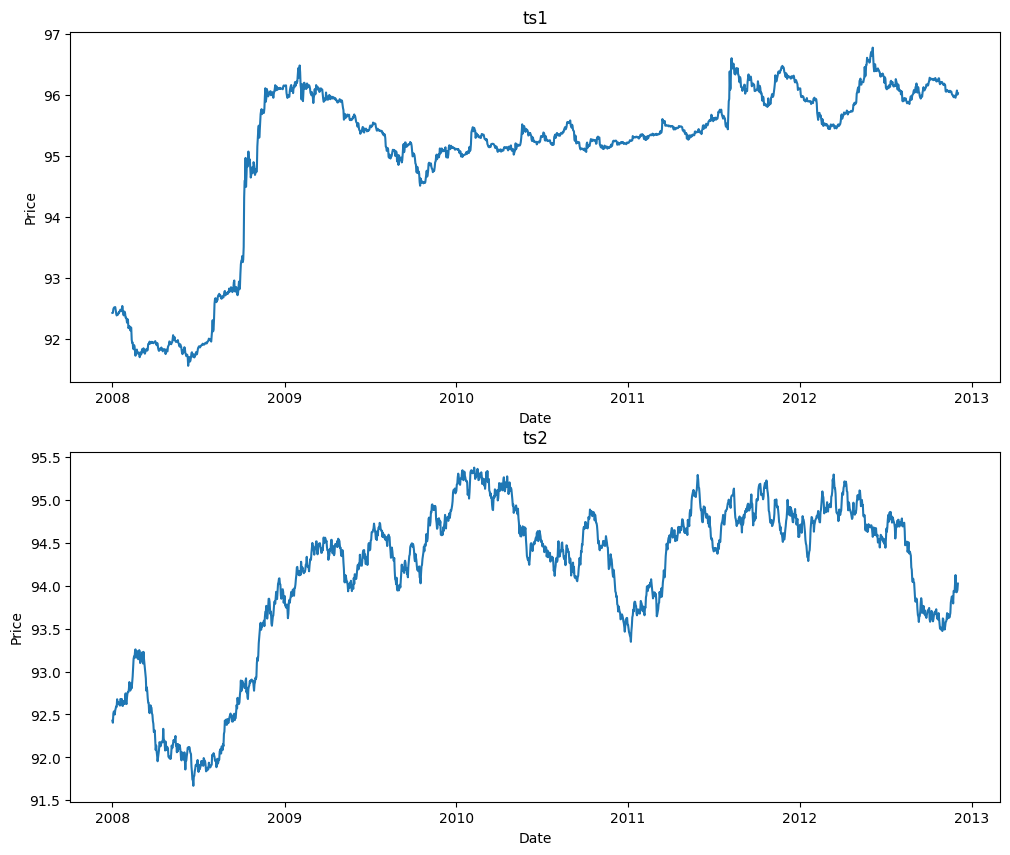

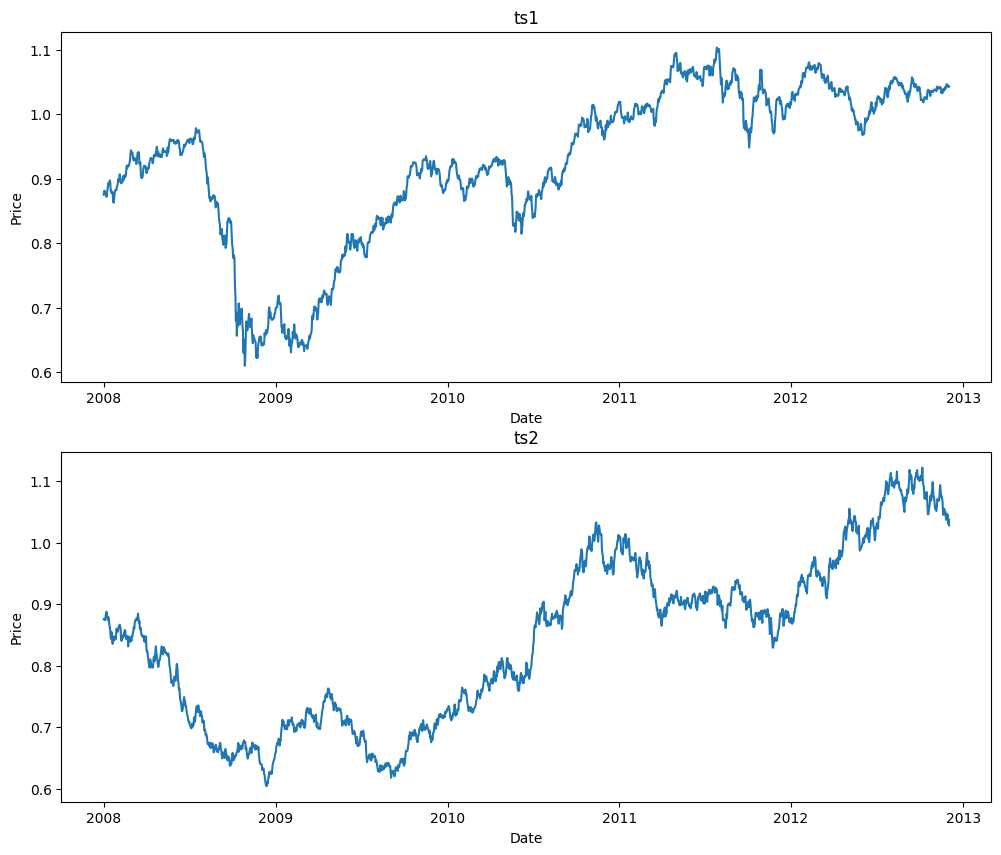

In [177]:
print(calculate_benchmark_errors_mult(ts_1_D_train,ts_2_D_train))

In [180]:
def monte_carlo_simulation(series1, series2, n_trials=10000):
    # Initialize a dictionary to store the accumulated evaluation results
    accumulated_results = {
        'Series1 Benchmark MAE': 0,
        'Series1 Benchmark MSE': 0,
        'Series1 Benchmark RMSE': 0,
        'Series1 Benchmark MAPE': 0,
        'Series1 Benchmark R2': 0,
        'Series1 Benchmark MSLE': 0,
        'Series2 Benchmark MAE': 0,
        'Series2 Benchmark MSE': 0,
        'Series2 Benchmark RMSE': 0,
        'Series2 Benchmark MAPE': 0,
        'Series2 Benchmark R2': 0,
        'Series2 Benchmark MSLE': 0,
    }

    for _ in range(n_trials):
        # Calculate benchmark errors for this trial
        trial_results = calculate_benchmark_errors_mult(series1, series2)

        # Accumulate the results of this trial
        for key in accumulated_results.keys():
            accumulated_results[key] += trial_results[key]

    # Average the accumulated results over the number of trials
    for key in accumulated_results.keys():
        accumulated_results[key] /= n_trials

    return accumulated_results

# Run the Monte Carlo simulation on your time series data
average_results = monte_carlo_simulation(ts_1_D_train, ts_2_D_train)
print(average_results)

{'Series1 Benchmark MAE': 1.7026368247071892, 'Series1 Benchmark MSE': 4.580922083616595, 'Series1 Benchmark RMSE': 1.9781187781137706, 'Series1 Benchmark MAPE': 0.01784666441062539, 'Series1 Benchmark R2': -1.5951537094959318, 'Series1 Benchmark MSLE': 0.0005024595958193135, 'Series2 Benchmark MAE': 0.19737058226206977, 'Series2 Benchmark MSE': 0.0698192329485169, 'Series2 Benchmark RMSE': 0.233018507543306, 'Series2 Benchmark MAPE': 0.2173549189155049, 'Series2 Benchmark R2': -3.8487946055213187, 'Series2 Benchmark MSLE': 0.016413276453302286}


    1.	Linear regression
    2.	Exponential smoothing
    3.	ARIMA
    3.  GARCH
    4.	Vector auto regression

    

In [72]:
# Models for testing

def fit_lr(train_x, train_y, test_x):
    # Create a LinearRegression object
    lr = LinearRegression()
    # Fit the model to the training data
    lr.fit(train_x, train_y)
    # Use the fitted model to make predictions on the test data
    test_y_pred = lr.predict(test_x)    
    # Return the predicted values
    return test_y_pred




def fit_simple_exponential_smoothing(train_x, train_y, test_x, test_y):
    model = SimpleExpSmoothing(train_y)
    model_fit = model.fit()
    ses_preds = model_fit.predict(len(test_y))
    return ses_preds

def fit_arima(train_x, train_y, test_x, test_y):
    arima = ARIMA(train_y, order=(1, 0, 1)).fit(disp=0)
    arima_preds = arima.predict(len(test_y))[0]
    return arima_preds

def fit_garch(train_x, train_y, test_x, test_y):
    garch = arch_model(train_y, vol='Garch', p=1, o=0, q=1).fit(disp='off')
    garch_preds = garch.predict(horizon=len(test_y), method='simulation').mean['h.1']
    return garch_preds

def fit_var(train_x, train_y, test_x, test_y):
    model = VAR(train_y)
    results = model.fit()
    lag_order = results.k_ar
    preds = results.predict(train_y.values[-lag_order:], len(test_y))
    return preds




Training and testing

Use AIC only for trad model testing

In [ ]:
# Define your models and their corresponding functions
models = {
    'linear_regression': predict_linear_regression,
    # ... add other models here
}

# Define a list of dataset combinations
dataset_combinations = [(data1, data2), (data1, data3), (data2, data3)]


ts_1_imp = clean_df['ts1']
ts_2_imp = clean_df['ts2']


In [ ]:
#First training and testing the models
# Iterate through all models and dataset combinations for training/testing and evaluation
model_evaluations = []
for model_name, predict_funct in models.items():
    for dataset_combination in dataset_combinations:
        # Split the data into features and labels
        X, y = dataset_combination[0], dataset_combination[1]
        # Iterate through the rolling forecast origin split
        for X_train, y_train, X_test, y_test in rolling_forecast_origin_split(X, y, window_size=30):
            # Train and test the model
            y_pred = predict_funct(X_train, y_train, X_test)
            # Evaluate the model
            accuracy, precision, recall = evaluate_model(y_test, y_pred)
            # Evaluate the predictions
            evaluation_result = evaluate(y_pred, y_test)

            # Print the evaluation metrics
            print(f"Model: {model_name}, Dataset Combination: {dataset_combination}")
            print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')
            print(f"Evaluation result: {evaluation_result}")

            # Append the evaluation results to the model_evaluations list
            evaluation_result.update({'model_name': model_name})
            model_evaluations.append(evaluation_result)     






Cross validation

Selecting best model + residuals

Optimsation + residuals

In [ ]:


def tune_sarima(y_train, seasonal=True):
    model = pm.auto_arima(y_train,
                          seasonal=seasonal,
                          stepwise=True,
                          suppress_warnings=True,
                          trace=True)
    return model




def tune_garch(y_train):
    best_aic = float("inf")
    best_order = None
    best_model = None

    for p in range(1, 4):
        for q in range(1, 4):
            try:
                model = arch_model(y_train, vol='Garch', p=p, q=q)
                results = model.fit(update_freq=5, disp='off')
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, q)
                    best_model = results
            except:
                continue

    print(f"Best GARCH model with order {best_order}")
    return best_model




def tune_var(endog_train, maxlags=15):
    best_aic = float("inf")
    best_lag = None
    best_model = None

    for lag in range(1, maxlags+1):
        model = VAR(endog_train)
        results = model.fit(lag)
        if results.aic < best_aic:
            best_aic = results.aic
            best_lag = lag  
            best_model = results
            
    print(f"Best VAR model with lag {best_lag}")
    return best_model





# 6. Exponential Smoothing (using sktime library):


def tune_exponential_smoothing(y_train):
    param_grid = {
        'smoothing_level': np.arange(0.1, 1.0, 0.1),
        'smoothing_trend': np.arange(0.1, 1.0, 0.1),
        'smoothing_seasonal': np.arange(0.1, 1.0, 0.1),
        'trend': ['add', 'multiplicative', None],
        'seasonal': ['add', 'multiplicative', None],
        'damped_trend': [True, False],
        'sp': [12]  # seasonal periodicity, change this value based on the seasonality in your data
    }
    model = ExponentialSmoothing()
    cv = SlidingWindowSplitter(window_size=12)  # change the window size based on the seasonality in your data
    grid = ForecastingGridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')
    grid.fit(y_train)
    best_params = grid.best_params_
    best_exp_smoothing_model = ExponentialSmoothing(**best_params)
    best_exp_smoothing_model.fit(y_train)
    
    print(f"Best Exponential Smoothing model with parameters {best_params}")
    return best_exp_smoothing_model




# These functions can be used for hyperparameter tuning of each model. Keep in mind that depending on the size of your dataset and the number of hyperparameters to be tuned, the tuning process might take a long time to complete. To speed up the process, you can adjust the parameter search space or use parallel processing if the library supports it (e.g., setting `n_jobs=-1` in LightGBM and scikit-optimize).



### Machine learning based modelling

2.	Log returns of original data and normalised/scaled
    1.	Random forest
    2.	SVM
    3.	Gaussian process
    4.	LightGBM XGBoost
    5.	LSTM

- Long Short-Term Memory (LSTM): A type of recurrent neural network that can learn long-term dependencies in a time series
   - i. Specify the appropriate architecture and hyperparameters, and use techniques such as dropout or early stopping to prevent overfitting


Feature generation
Create additional features using date breakdown of dateitem index

Models definition

In [ ]:
def train_random_forest(train_x, train_y, test_x, test_y):
    model = RandomForestRegressor()
    model.fit(train_x, train_y)
    preds = model.predict(test_x)
    mse, mae, mape = evaluate_predictions(test_y, preds)

    print("Random Forest")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"MAPE: {mape:.3f}")
    
    return mse, mae, mape

def train_gaussian_process(train_x, train_y, test_x, test_y):
    # Fit Gaussian Process model
    kernel = ConstantKernel() * RBF()
    model = GaussianProcessRegressor(kernel=kernel)
    model.fit(train_x, train_y)

    # Make predictions
    preds, std = model.predict(test_x, return_std=True)

    # Evaluate predictions
    mse, mae, mape = evaluate_predictions(test_y, preds)

    print("Gaussian Process")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"MAPE: {mape:.3f}")
    
    return mse, mae, mape

def train_lightgbm(train_x, train_y, test_x, test_y):
    # Fit LightGBM model
    params = {'objective': 'regression'}
    d_train = lgb.Dataset(train_x, label=train_y)
    model = lgb.train(params, d_train)
    preds = model.predict(test_x)

    # Evaluate predictions
    mse, mae, mape = evaluate_predictions(test_y, preds)

    print("LightGBM")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"MAPE: {mape:.3f}")
    
    return mse, mae, mape

LSTM

In [ ]:


def create_dataset(dataset, look_back=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - look_back):
        data_x.append(dataset[i:(i + look_back), 0])
        data_y.append(dataset[i + look_back, 0])
    return np.array(data_x), np.array(data_y)

def unscale_data(pred, actual):
    scaler = MinMaxScaler()
    scaler.fit(actual)
    pred = scaler.inverse_transform(pred)
    actual = scaler.inverse_trans
    form(actual)
    return pred, actual


def scale_data(train_data, test_data):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)
    return train_scaled, test_scaled


def fit_lstm(train_x, train_y, test_x, test_y, lstm_units=50, look_back=1, num_epochs=10, batch_size=32):
    # Reshape input to be [samples, time steps, features]
    train_x = train_x.reshape((train_x.shape[0], look_back, 1))
    test_x = test_x.reshape((test_x.shape[0], look_back, 1))

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(8, input_shape=(look_back, 1), return_sequences=True))
    model.add(LSTM(4))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape'])

    # Fit the model
    model.fit(train_x, train_y, epochs=num_epochs, batch_size=batch_size, verbose=2)

    # Make predictions
    train_pred = model.predict(train_x)
    test_pred = model.predict(test_x)

    # Inverse scaling of the predictions
    train_pred = scaler.inverse_transform(train_pred)
    train_y = scaler.inverse_transform(train_y)
    test_pred = scaler.inverse_transform(test_pred)
    test_y = scaler.inverse_transform(test_y)

    # Create a DataFrame of the predictions and actual values
    train_results = pd.DataFrame({'Actual': train_y.flatten(), 'Predicted': train_pred.flatten()}, index=train_data.index[1:])
    test_results = pd.DataFrame({'Actual': test_y.flatten(), 'Predicted': test_pred.flatten()}, index=test_data.index[1:])

    # Evaluate the predictions
    train_mse, train_mae, train_mape = evaluate_predictions(train_y, train_pred)
    test_mse, test_mae, test_mape = evaluate_predictions(test_y, test_pred)
    
    # Evaluate the model on the test set
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test loss: {loss}")

    # Print the evaluation metrics
    print("Train MSE: {:.3f}, Train MAE: {:.3f}, Train MAPE: {:.3f}".format(train_mse, train_mae, train_mape))
    print("Test MSE: {:.3f}, Test MAE: {:.3f}, Test MAPE: {:.3f}".format(test_mse, test_mae, test_mape))

    return pd.concat([train_results, test_results])


Main model testing

Model tuning

In [ ]:

# 4. LSTM (using Keras library):


def build_lstm_model(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def tune_lstm(X_train, y_train):
    param_grid = {
        'units': [50, 100],
        'activation': ['relu', 'tanh'],
        'optimizer': [Adam(learning_rate=0.001), Adam(learning_rate=0.01)]
    }
    model = KerasRegressor(build_fn=build_lstm_model, epochs=50, batch_size=32, verbose=0)
    tscv = TimeSeriesSplit(n_splits=5)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_result = grid.fit(X_train, y_train)
    best_params = grid_result.best_params_
    best_lstm_model = build_lstm_model(**best_params)
    best_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
    print(f"Best LSTM model with parameters {best_params}")
    return best_lstm_model




# 5. LightGBM (using LightGBM library and scikit-optimize):



def tune_lightgbm(X_train, y_train):
    param_space = {
        'learning_rate': Real(0.01, 0.1),
        'n_estimators': Integer(100, 1000),
        'max_depth': Integer(3, 10),
        'num_leaves': Integer(31, 200),
        'min_child_samples': Integer(20, 100)
    }
    
    model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_jobs=-1)
    tscv = TimeSeriesSplit(n_splits=5)
    bayes_cv = BayesSearchCV(model, param_space, n_iter=50, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    bayes_cv.fit(X_train, y_train)
    best_params = bayes_cv.best_params_
    best_lgbm_model = lgb.LGBMRegressor(**best_params)
    best_lgbm_model.fit(X_train, y_train)

    print(f"Best LightGBM model with parameters {best_params}")
    return best_lgbm_model

Cross validation

Residuas and diagn


Optimsation and residuals


### Model validation

In [ ]:


def validate_model_and_confidence_intervals(model, test_x, test_y, confidence_level=0.95):
    """
    Performs model validation and calculates confidence intervals for the provided model and test data.

    Parameters:
    model (object): A trained time series model.
    test_x (array-like): The input data for out-of-sample or hold-out validation.
    test_y (array-like): The target data for out-of-sample or hold-out validation.
    confidence_level (float): The confidence level for the prediction intervals.

    Returns:
    dict: A dictionary containing the predicted values, lower and upper bounds of the prediction intervals, and the actual values.
    """
    # Make forecasts on the out-of-sample data or hold-out validation set
    forecast_result = model.get_forecast(steps=len(test_y))
    forecast_mean = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int(alpha=(1 - confidence_level))

    # Extract the lower and upper bounds of the prediction intervals
    lower_bound = forecast_ci.iloc[:, 0]
    upper_bound = forecast_ci.iloc[:, 1]

    # Compare the actual values to the predicted values and their associated prediction intervals
    results = {
    'predicted_values': forecast_mean,
    'lower_bound': lower_bound,
    'upper_bound': upper_bound,
    'actual_values': test_y}
    
    return results


# Example usage:
# Assuming you have a trained ARIMA model arima_model, test data X_test, y_test, and a confidence level of 0.95
validation_results = validate_model_and_confidence_intervals(arima_model, X_test, y_test, confidence_level=0.95)

# Print the results
print("Predicted Values:", validation_results['predicted_values'])
print("Lower Bound:", validation_results['lower_bound'])
print("Upper Bound:", validation_results['upper_bound'])
print("Actual Values:", validation_results['actual_values'])

# This function will return a dictionary containing the predicted values, lower and upper bounds of the prediction intervals, and the actual values. You can then use these values to analyze the model's performance on the out-of-sample data or hold-out validation set.
    
    

### Model selection based on performance and diagnostics: 
 - Review the evaluation metrics, cross-validation results (if performed), and diagnostic tests for each candidate model. 
- Consider trade-offs between model complexity, interpretability, and performance. 
- Analyze the results of the best models for each - hypothesis
- Sraw conclusions based on the model performance and the significance of their predictive power
- Choose the best model(s) based on the comparison of their performance metrics of the best models for each hypothesis to ensure their validity
- Select the best model based on a combination of performance metrics, robustness, and model diagnostics.


Discussion: When you have selected the best model, you can perform sensitivity analysis to understand the impact of changes in input features on the forecasted stock prices. This will help you gauge the model's robustness and stability.

use a grid search or optimization algorithm to find the optimal window size for a given model and dataset. This approach involves trying a range of window sizes and selecting the one that results in the best performance on a validation set. This approach can be computationally intensive, but it can lead to better performance than using a fixed or adaptive window size.

USe automl
inverstigate different window sizes for splitting training and testing data

consider ensembling models to see if prediciton can be improved.  

Feautre engineering:
    - Separate the data by time index
    - SMA
    - MACD
    - RSI


Aply clustering analysis to the squared returns to find when there are similar periods of high or low volatility to inform modelling and risk management

use clutering aalysis as well to determien outliers: such as DBSCAN or HDBSCAN, to group  data points based on their similarity. These algorithms can identify clusters of data points and label the points that do not belong to any cluster as outliers. Python's sklearn.cluster module provides an implementation of DBSCAN, and the hdbscan library provides an implementation of HDBSCAN.


Data cleaning:

the quality of your data is crucial for the success of your models. It's always a good idea to perform a sensitivity analysis to assess the impact of missing data on your model's performance and make adjustments as needed.


Hyperparameter Tuning
perform hyperparameter tuning (e.g., using grid search, random search, or Bayesian optimization) to find the optimal set of parameters.